# Introduction

This notebook implements the [VotingClassifier](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), in which multiple:
* predictions are gathered and the plurality vote wins
* probabilities are gathered and aggregated to produce an ensembled set of probabilities


## Summary
* the [results](#Results-of-test-AUC) show that the test AUC is the highest so far at 0.69658
* the VotingClassifier is heavily overfit with a training and validation AUC of 0.993 and 0.698, respectively
* the class 0 f1-score are also the highest at 0.09, while maintaining the class 1 f1-score at 0.91

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from datetime import datetime

from src.data.make_dataset import load_sets, save_sets, save_predictions, make_adversarial_validation_dataset, load_estimators
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [6]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

In [7]:
target = 'TARGET_5Yrs'

# Baseline

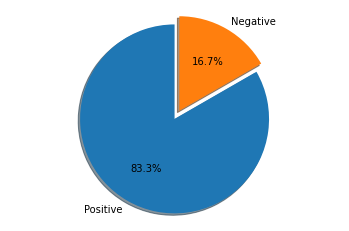

In [8]:
plot_pie(y_train)

# Load estimators

Note that some estimators are not compatible with the `VotingClassifier`, so these are popped from the list.

In [17]:
estimator_list = load_estimators(models_dir)

Loading 10906675_xgb_es_spw.joblib
Loading 10906675_xgb_es_spw_1_comp.joblib
Loading 10906675_xgb_es_spw_cal.joblib
Loading exploratory_xgb.joblib
Loading randomised_xgb.joblib
Loading xgb_top_8_features_early_stopping.joblib
Loading brackenrig_mark_12964298_week1_votingclassifier.sav
Loading brackenrig_mark_12964298_week2_SMOTE.sav


Changing the `RandomisedSearchCV` object to the actual estimator object (`Pipeline`).

In [18]:
estimator_list[4] = ('randomised_xgb.joblib', estimator_list[4][1].best_estimator_)

The `VotingClassifier` throws an error for `CalibratedClassifierCV` objects, saying that it's not yet fitted, so they're excluded for now.

In [19]:
# Drop the one that is already a voting classifier
estimator_list.pop(7)
estimator_list.pop(6)
estimator_list.pop(2)

('10906675_xgb_es_spw_cal',
 CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scaler',
                                                        StandardScaler()),
                                                       ('pca',
                                                        PCA(n_components=8)),
                                                       ('classifier',
                                                        XGBClassifier(base_score=0.5,
                                                                      booster='gbtree',
                                                                      colsample_bylevel=1,
                                                                      colsample_bynode=1,
                                                                      colsample_bytree=0.590700201239684,
                                                                      eval_metric='logloss',
                                                                  

In [22]:
clf = VotingClassifier(estimators=estimator_list,
                       voting='soft',
                       n_jobs=-1,
                       verbose=True)

start = datetime.now()
print(f'Started: {start}')

clf.fit(X_train, y_train)

end = datetime.now()
print(f'Started: {end}')
print(f'Run time: {end - start}')

Started: 2021-02-21 14:45:04.339028
Started: 2021-02-21 14:45:09.569773
Run time: 0:00:05.230745


 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[ 396  672]
 [   0 5332]]
Accuracy:  0.895
AUC:  0.9934539463517564
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      1068
           1       0.89      1.00      0.94      5332

    accuracy                           0.90      6400
   macro avg       0.94      0.69      0.74      6400
weighted avg       0.91      0.90      0.87      6400



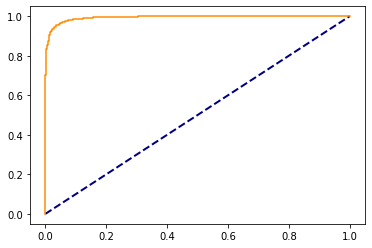

In [23]:
classification_reports(clf, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  13  250]
 [  22 1315]]
Accuracy:  0.83
AUC:  0.697569326936476
              precision    recall  f1-score   support

           0       0.37      0.05      0.09       263
           1       0.84      0.98      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.61      0.52      0.50      1600
weighted avg       0.76      0.83      0.77      1600



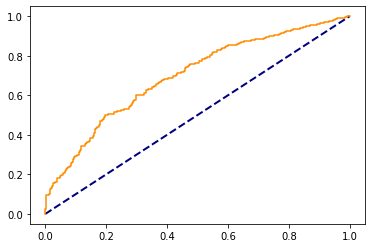

In [24]:
classification_reports(clf, X_val, y_val)

# Save model

In [25]:
model_name = '10906675_voting_classifier'
model_path = models_dir / model_name
dump(clf, model_path.with_suffix('.joblib'))

['D:\\Projects\\assignment_1\\models\\10906675_voting_classifier.joblib']

# Prediction on test set

In [26]:
probs = clf.predict_proba(X_test)[:, 1]

In [35]:
probs

array([0.65319955, 0.65564203, 0.72314936, ..., 0.60709983, 0.72595614,
       0.6344749 ], dtype=float32)

In [28]:
path = processed_data_dir / f'probs_{model_name}.csv'
save_predictions(probs, 'TARGET_5Yrs', test_id, path)

## Submit predictions

In [29]:
api.competition_submit(file_name=path,
                       message=model_name,
                       competition=competition,
                       quiet=False)

100%|█████████████████████████████████████████████████████████████████████████████| 59.5k/59.5k [00:07<00:00, 8.10kB/s]


Successfully submitted to [UTS AdvDSI] NBA Career Prediction

# Results of test AUC

The test AUC is 0.69658.